**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Music genre classification on unbalanced dataset* 

## Abstract

Music genre classification is a challenging problem in the Machine Learning world. In this project, we propose the process of building and tuning a Machine Learning model that achieved up to an average accuracy of 66% when predicting ten music genres. The process includes features tuning, making algorithms choice, model tuning and enhancing model's accuracy using Voting ensemble and Semi supervised learning.

## 1. Introduction

The rapid evolvement of digital music rises many challenges in efficient uses of the enormous music database, which involve music genre recommendation, mood-based music recommendation etc. Automatic music genre classification emerges as a potential solution for many of those aformentioned tasks. However, given the subjective nature of music, the challenge of building a highly accurate classfication model is daunting one. 

In this project, we employ the use of various machine learning algorithms, including Random Forest Classfication, multi-class SVM, k-neighbors classifier, Linear Discriminant Analysis to classify the following 10 genres: Pop Rock, Electronic, Rap, Jazz, Latin, RnB, International, Country, Reggae and Blues. To achieve this, we investigate and peform the machine learning algorithms on a relatively big and highly dimensional dataset.

Data analytics is challenging since it requires knowledge in many domains, including problem specific knowledge, machine learning, data visualization etc. It goes without saying that the data analytics tasks involve a lot of trial and error, hence acquiring on-hand experience from the early stage will definitely prove valuable in the long run. That said, upon completing the project, we hope to gain an insight into working with a real-world data problem, gaining experience from making mistakes and learning how to tackle a problem from multiple angles. We would like to address the following problems throughout the project:
1. How to analize a dataset correctly ?
2. Algorithm evaluation.
3. Strategies for working with unbalanced dataset ?
4. How to improve model accuracy through hyperparemeters tuning and resampling?


## 2. Data analysis

In [41]:
%matplotlib inline

# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import random

##Preprocession

#Model splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

##Features tuning

#Dimensionality reduction
from sklearn.preprocessing import StandardScaler


##Params tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

#SMOTE
!pip install imblearn
!pip install xgboost

from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.linear_model import LinearRegression

#Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

#CV validation
from sklearn.model_selection import StratifiedKFold

#Pipeline
from sklearn.pipeline import Pipeline

import warnings

#Ignore warning
warnings.simplefilter(action='ignore')


You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [42]:

test_data = pd.read_csv("test_data.csv", header=None) 
train_data = pd.read_csv("train_data.csv", header=None) 
train_labels = pd.read_csv("train_labels.csv", header=None) 

X_test = test_data.values # (6544, 264)
y_final = np.zeros((X_test.shape[0],1))

X = train_data.values # (4363, 264)
y = train_labels.values # (4363, 1)

genres = ['Pop Rock','Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae','Blues']

The train dataset contains __4363__ samples and __264__ features each. Accordingly, there are __4363__ labels. 

Before splitting the train dataset into train and validation set, we perform standardization on both the test and training set. 


## 2.1 Feature engineering

Firstly, we standardize all features.

In [43]:
from sklearn.preprocessing import StandardScaler

#Standardization

std_scaler = StandardScaler()
std_scaler.fit_transform(X)
std_scaler.fit_transform(X_test)


array([[ 0.04382574, -0.80976693, -0.94563473, ...,  1.64699758,
         0.15993277,  1.25380542],
       [-0.76499397, -0.76013062, -1.31811073, ...,  1.20939201,
         1.32983447,  0.43684169],
       [-1.11109711, -0.39532397, -0.27109317, ..., -0.18441099,
        -0.86473105, -0.88355397],
       ..., 
       [-1.28590284, -1.45941064, -1.6464014 , ..., -1.18319724,
        -0.82856509, -1.26701448],
       [ 0.65831516, -0.06744188, -0.58738386, ...,  0.19591376,
         0.23295355, -0.20519107],
       [-0.81487309, -0.39310446, -0.42717229, ..., -0.33385487,
        -0.74838766, -0.00704158]])

Then, we perform recursive feature selection with Linear Discriminant Analysis as estimator, scoring method is __f1__. Reason for choosing __f1__ as scoring method is explained below.

In [44]:
from sklearn.feature_selection import RFECV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

skf = StratifiedKFold(n_splits = 10)
lda = LinearDiscriminantAnalysis() 

rfecv = RFECV(estimator=lda, step=1, cv=skf ,scoring='f1_macro')   #10-fold cross-validation
X = rfecv.fit_transform(X,y)

Optimal number of features: 210


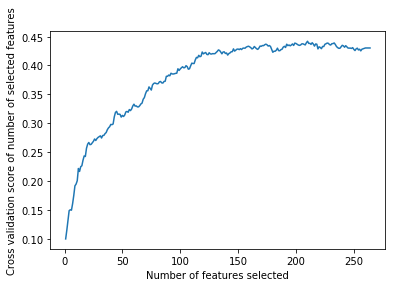

In [45]:
import matplotlib.pyplot as plt

X_test = rfecv.transform(X_test)
print('Optimal number of features:',rfecv.n_features_)

plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


The train dataset is then split into 2 subsets namely __train__ and __validation__ with a 7:3 ratio.

In [46]:

seed = 69

X_train,X_val,y_train, y_val = train_test_split(X,y,test_size=0.33,random_state = seed)


Then, we plot the distribution histogram of the train labels.

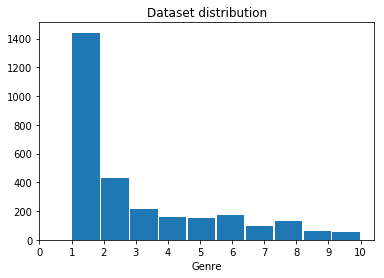

In [47]:

# the histogram of the data
def plotLabelData(Y):
    fig,ax = plt.subplots()
    
    plt.title('Dataset distribution')
    ax.hist(Y, bins=10,rwidth=0.95)
    plt.xlabel('Genre')
    ax.set_xticks(ticks=range(0,11))
    ax.set_xticklabels(range(0,11))
    
    plt.show()

plotLabelData(y_train)

In [48]:
#Class distribution, raw data

def printGenreDistribution(y):
    for i in range(len(genres)):
        sample_count = y.ravel().tolist().count(i+1)
        sample_percentile = round(sample_count/len(y.tolist())*100, 2)
        print (genres[i],":",sample_count,"(",sample_percentile,"%)")
    print("Total: ",len(y.tolist()))

printGenreDistribution(y_train)


Pop Rock : 1441 ( 49.3 %)
Electronic : 433 ( 14.81 %)
Rap : 214 ( 7.32 %)
Jazz : 159 ( 5.44 %)
Latin : 152 ( 5.2 %)
RnB : 171 ( 5.85 %)
International : 99 ( 3.39 %)
Country : 134 ( 4.58 %)
Reggae : 64 ( 2.19 %)
Blues : 56 ( 1.92 %)
Total:  2923


There dataset is  unbalanced. __Pop rock__ genre accounts for more than 50% of all samples.



The feature space contains of 264 dimensions and is divided into 3 categories namely Rhythm pattern, Chroma and MFCC respectively. Upon investigation, it is suggested that MFCC is frequently used in acoustic sound processing and therefore has the potential score high during features ranking phase. [1]


## 3. Methods and experiments

The overall training procedure consists of 6 steps:
1. Trial various algorithms
    - For this problem, we decided to experiment the following algorithms: k-neighbors, SVC with rbf kernel, Random Forest classfier and Linear Discriminant Classifier

2. Pick out the best algorithms
    - Using cross validation, we pick out the 2 models with the best mean score and lowest variance
   
3. Diagnose overfitting/underfitting
    - Predict and observe the score on test set
 
4. Enhancing 
    - We further elaborate the results and try using Voting ensemble and semi supervised learning  to improve the accuracy. 
        1. Try semi supervised learning using pseudo labeling.
        2. Investigate the if there is change in accuracy score after training with the augmented dataset.
        3. Pick out the best algorithms and use Voting ensemble to improve final score.
        
5. Make prediction on test dataset

As noted above, the dataset is unbalanced. Thefore, choosing __accuracy__ as scoring metric will likely produce misleading result, since the model will bias toward the majority class and yield unrealisticly high accuracy score. 
On the other hand, __precision, recall__ and __f1__ scores which reflect True Positive, False Positive, True Negative, False Negative gives better insight toward the uneven classes. Therefore, we will elaborate on thoses scores when investigating the chosen algorithms. [3]


We define a helper method that helps printing out the training results


In [49]:
from sklearn.metrics import balanced_accuracy_score

def printResult(y_val,y_pred):
    print("Accuracy: ",accuracy_score(y_val, y_pred))
    print("Confusion matrix: \n",confusion_matrix(y_val, y_pred))
    print("Classification report: \n",classification_report(y_val, y_pred))

## 3.1 Trialing

In [50]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [51]:
seed = 32

models = []
models.append(('SGD', SGDClassifier()))
models.append(('XGB', XGBClassifier(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('RFC', RandomForestClassifier()))
models.append(('ETC', ExtraTreesClassifier()))

def trialAlgorithms(models,X,y ,scoring='f1_macro'):
    results = []
    names = []
    kfold = StratifiedKFold(n_splits=10, random_state=seed)
    for name, model in models:
        cv_results = cross_val_score(model, X, y.ravel(), cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    
    return names,models,results

print("Inital trial algorithms on original dataset")
names,models,results = trialAlgorithms(models,X_train, y_train)


Inital trial algorithms on original dataset
SGD: 0.179442 (0.048928)
XGB: 0.341946 (0.034352)
LDA: 0.431967 (0.033166)
RFC: 0.232999 (0.020390)
ETC: 0.205628 (0.022840)


Initial result shows that XGBoost and Linear Discriminant algorithms yield the highest accuracy score. Therefore, we further try to tune the hypermeters and train the two models.

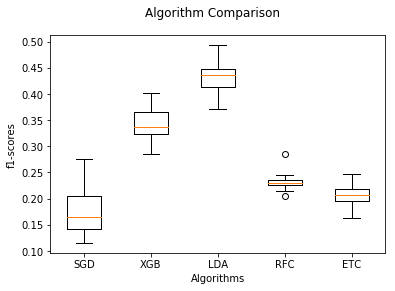

In [52]:
def plotBenchmarkResults(results,names):
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    plt.ylabel('f1-scores')
    plt.xlabel('Algorithms')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

plotBenchmarkResults(results,names)

The boxplot depicts the result from cross-validation scores. The variance and median is both acceptable, which means that the models are doing fine on the given dataset.

## 3.2 Predict using selected models

Firstly, we examine training the data on XGBoost model [2]. The hyperparameters were tuned using GridSearchCV. The tuning process takes a lot of time hence results in the selected hyperparameters.

In [53]:

#Trial XGB

def trialXGB(X,y,X_val=X_val):

    xgb = XGBClassifier(learning_rate =0.01,
                             n_estimators=1000,
                             max_depth=10,
                             min_child_weight=1,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=69,
                              n_jobs=-1)
    xgb.fit(X,y.ravel())
    y_pred = xgb.predict(X_val)
    printResult(y_pred,y_val)
    return xgb

xgb = trialXGB(X_train,y_train)

Accuracy:  0.657638888889
Confusion matrix: 
 [[683  66  25  40  41  43  33  54   9  24]
 [ 29 108   8  13   0   5   3   0   3   0]
 [ 12  10  74   0   2  12   2   1   7   0]
 [  1   0   0  37   1   2   1   0   0   1]
 [  2   0   1   0   9   1   1   1   1   2]
 [  6   1   3   4   5  26   2   0   3   1]
 [  1   0   0   0   0   0   0   0   0   1]
 [  1   0   0   0   0   0   0   5   0   1]
 [  1   0   1   0   3   0   0   0   5   0]
 [  1   0   0   0   1   0   0   0   0   0]]
Classification report: 
               precision    recall  f1-score   support

           1       0.93      0.67      0.78      1018
           2       0.58      0.64      0.61       169
           3       0.66      0.62      0.64       120
           4       0.39      0.86      0.54        43
           5       0.15      0.50      0.23        18
           6       0.29      0.51      0.37        51
           7       0.00      0.00      0.00         2
           8       0.08      0.71      0.15         7
           

Next, we construct a LDA classifier and observe its accuracy when predicting the validation dataset

In [54]:

#Trial LDA
def trialLDA(X,y,X_val=X_val):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X,y.ravel())
    y_pred = lda.predict(X_val)
    printResult(y_pred,y_val)
    return lda

lda = trialLDA(X_train,y_train)

Accuracy:  0.66875
Confusion matrix: 
 [[630  43  18  23  28  24  14  32   1  11]
 [ 39 114   6   7   1   2   3   0   3   0]
 [  7   8  73   0   2  11   1   1   4   1]
 [ 12   9   1  49   2   4   2   0   0   2]
 [  8   3   1   1  11   6   7   1   2   4]
 [ 12   2   3   8   7  37   4   1   5   3]
 [  4   3   0   1   2   0   6   0   0   1]
 [ 14   0   3   2   1   2   3  24   0   1]
 [  2   3   7   0   6   2   1   0  13   1]
 [  9   0   0   3   2   1   1   2   0   6]]
Classification report: 
               precision    recall  f1-score   support

           1       0.85      0.76      0.81       824
           2       0.62      0.65      0.63       175
           3       0.65      0.68      0.66       108
           4       0.52      0.60      0.56        81
           5       0.18      0.25      0.21        44
           6       0.42      0.45      0.43        82
           7       0.14      0.35      0.20        17
           8       0.39      0.48      0.43        50
           9      

The model yields a 63% accuracy score which beats the benchmark. However, when observing the confusion matrix, we can see that the model often mislabel the minority genres. F1 score is noticeably low on class number 5, 7 and 10 where almost 50% of the sample is classified as belonging to class number 1.

Next, we examine Random Forest Classifier. This time we provide the classifier with some class weights. The idea is to heavily penalize misclassfication in minority classes.

In [55]:

#Trial Random Forest

def trialRFC(X,y,X_val=X_val,class_weight='balanced'):
    rfc = RandomForestClassifier(class_weight=class_weight,
                                 n_estimators=1000,
                                 max_features = 'auto',
                                 min_samples_leaf = 1,
                                 max_depth=10)
    rfc.fit(X,y.ravel())
    y_pred = rfc.predict(X_val)
    printResult(y_pred,y_val)
    return rfc

rfc = trialRFC(X_train,y_train)


Accuracy:  0.626388888889
Confusion matrix: 
 [[616  60  16  24  29  13  25  33   2  15]
 [ 41 100  14  23   3   7   2   0   7   1]
 [ 15  16  77   0   7  17   2   1  11   2]
 [ 11   8   0  40   3   4   3   2   0   4]
 [  8   0   0   1   9   5   3   2   1   2]
 [ 17   1   3   6   9  36   3   4   2   3]
 [  1   0   0   0   0   0   0   0   0   0]
 [ 27   0   0   0   2   6   4  18   0   2]
 [  1   0   2   0   0   0   0   0   5   0]
 [  0   0   0   0   0   1   0   1   0   1]]
Classification report: 
               precision    recall  f1-score   support

           1       0.84      0.74      0.78       833
           2       0.54      0.51      0.52       198
           3       0.69      0.52      0.59       148
           4       0.43      0.53      0.47        75
           5       0.15      0.29      0.19        31
           6       0.40      0.43      0.42        84
           7       0.00      0.00      0.00         1
           8       0.30      0.31      0.30        59
           

The model with provided hyperparameters yields better accuracy compared to the previous default one. Recall score is still low and the model tends to misclassify the majority class rather than giving a false positive results on the minority class.

Since the dataset is unbalanced, it is likely that the predicted results will be highly biased towards the majority class. The training results confirm our assumption and thefore we decided to try resampling the classes to make the data distribution more balanced. The balanced dataset will be used to train the previous models. [4]


### 3.3. Resampling

One approach to improve training result on unbalanced dataset is to try rebalance them by either create more samples for the minority class (oversampling) or delete samples from the majority class (undersampling). Given that the training dataset is quite small (<10000 samples), undersampling may eventually lead to underfitting. Therefore, we try to oversampling the dataset using Synthetic Minority Over-sampling technique (SMOTE) [5].

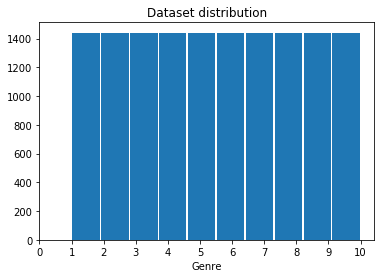

In [56]:
from imblearn.over_sampling import SMOTE

def balancedDatasetUsingRandomOverSampler(X,y,sampling_strategy={}):
    smote = SMOTE()
    X_res,y_res = smote.fit_resample(X,y.ravel())
    return X_res,y_res

X_oversampled, y_oversampled = balancedDatasetUsingRandomOverSampler(X_train,y_train)
plotLabelData(y_oversampled)


In [1]:
selected_models = []
selected_models.append(('XGB', xgb))
selected_models.append(('LDA', lda))
selected_models.append(('RFC', rfc))
names, models, results = trialAlgorithms(selected_models,X_oversampled, y_oversampled,scoring='f1_macro')
plotBenchmarkResults(results,names)

NameError: name 'xgb' is not defined

Overall, we observe an increase in f1 score when trialling with the oversampled dataset. However, the variance is high as well which suggests overfitting in the models.

Next, we train the previous models with the resampled data

In [ ]:
#XGB
print('Accuracy report for XGB')
trialXGB(X_oversampled, y_oversampled)

#LDA
print('Accuracy report for LDA')
trialLDA(X_oversampled,y_oversampled)

#RC
print('Accuracy report for RFC')
trialRFC(X_oversampled,y_oversampled,class_weight=None)


Training the selected models with the resampled dataset results in a dramatic drop in accuracy and precision, recall, f1 score. For the simplicity of this project, we decided not to further elaborate on the result when training with oversampled dataset, but focus on other enhancement methods.

## 3.4 Enhancement methods

### 3.4.1 Pseudo label

We try to enhancing the model's accuracy by applying semi supervised learning. The idea of semi supervised is that, after training a model with the train data, we create pseudo labels from the training result and add them into the current training set. By doing so, we are trying to improve the decision boundary of the model and therefore hoping for an improvement in training's result. [6]


In [ ]:
from sklearn.utils import shuffle

def create_augmented_train(model, X_train, y_train, X_val, target, sample_rate = 0.6):
    '''
    Create and return the augmented_train set that consists
    of pseudo-labeled and labeled data.
    '''
    num_of_samples = int(len(X_val) * sample_rate)
    entry_index = random.randint(0, len(X_val)-num_of_samples)
    # Train the model and create the pseudo-labels
    model.fit(X_train, y_train)
    pseudo_labels = model.predict(X_val)
    
    X_train_pseudo = X_val[entry_index:entry_index+num_of_samples,:]
    y_train_pseudo = pseudo_labels[entry_index:entry_index+num_of_samples]

    X_train_augmented = np.vstack((X_train,X_train_pseudo))
    y_train_augmented = np.vstack((y_train,y_train_pseudo.reshape((y_train_pseudo.shape[0], 1))))
    
    X_train_augmented, y_train_augmented = shuffle(X_train_augmented,y_train_augmented,random_state=342)
    return X_train_augmented, y_train_augmented


In [ ]:
#Traning XGB with augmented labels

X_train_augmented,y_train_augmented = create_augmented_train(xgb,X_train,y_train,X_val,y_val,sample_rate=0.2)
xgb.fit(X_train_augmented,y_train_augmented)
y_pred = xgb.predict(X_val)
printResult(y_pred,y_val)

In [ ]:
#Traning LDA with augmented labels

X_train_augmented,y_train_augmented = create_augmented_train(lda,X_train,y_train,X_val,y_val,sample_rate = 0.3)
lda.fit(X_train_augmented,y_train_augmented)
y_pred = lda.predict(X_val)
printResult(y_pred,y_val)

In [ ]:
#Traning RC with augmented labels

X_train_augmented,y_train_augmented = create_augmented_train(rfc,X_train,y_train,X_val,y_val,sample_rate=0.6)
rfc.fit(X_train_augmented,y_train_augmented)
y_pred = rfc.predict(X_val)
printResult(y_pred,y_val)

Overall, we observe a slight improvement in accuracy score when training with the augmented data.

### 3.4.2 Voting

Finally, we put all the best classifiers we have trained so far into a Voting ensemble. Given the past performance of the model, we assign some scales, in a sense that better models will be given heavier scales, hence have more impact on the final decision. [7]

In [ ]:
from sklearn.ensemble import VotingClassifier

X_train_augmented,y_train_augmented = create_augmented_train(lda,X_train,y_train,X_val,y_val)
voting = VotingClassifier(estimators=[('lda',lda),('xgb',xgb),('rfc',rfc)],voting='soft',weights=[1.3,.8,0.6],n_jobs=-1)
voting.fit(X_train_augmented,y_train_augmented)
y_pred = voting.predict(X_val)
printResult(y_pred,y_val)

## 4. Results

In [ ]:
def printAccuracy(y):
    df = pd.DataFrame(y)
    df.index+=1
    df.index.name = 'Sample_id'
    df.columns =['Sample_label']
    df.to_csv('final_acc.csv')

y_test_pred = voting.predict(X_test)

printAccuracy(y_test_pred)

In [ ]:
def printLogloss(y):
    df = pd.DataFrame(y)
    df.index+=1
    df.index.name = 'Sample_id'
    df.columns =['Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9','Class_10']
    df.to_csv('final_logloss.csv')
    
y_test_pred = voting.predict_proba(X_test)
printLogloss(y_test_pred)


The best score the model achieved in Kaggle for accuracy competition was 66.53%, which is approximately 1% lower compared to the test data.

The best score the model achieved in Kaggle for log-loss competition was 17.23%.

## 5. Discussion/Conclusions

Accuracy metric tends to be a misleading measure when working with imbalanced dataset. Often the model will tend to classify all samples as the majority class and easily achieve a high accuracy score. In this case, the accuracy score is better than 50%, since the majority class accounts for 50% of all samples.

Investigating the classification report, we observe a low accuracy and a good recall point for the majority class. Whereas, as can be observed from the confusion matrix, the model performs poorly on the minority classes, often misclassfies them as the majority class. The model perform poorly on particular class (5th, 7th, 10th), achieves less than 10% in recall score.

Resampling did not really help improve the model performance in this case. The result after resampling suggested that there was an overfit in the model when training with the oversampled dataset. This in turn led to low accuracy when predicting the values from validation set. Better tuning of features set could help the cause. Although, on the other hand, our main approach was to tune the model so that it could deal better with imbalanced data (assigning weights for classes etc.), therefore we did not spend so much time on model tuning for resampled dataset.

The project also illustrated the importance of feature engineering. For the first few entries, we put our focus on hyperparameters tuning and models choice. The outcome was not impressive since the accuracy score did not increase significantly. After experimenting with different feature engineering methods, we observed a notable improvement after performing Recursive Feature Elimination. Training the refined features boost the model performance by a certain degree. The outcome accuracy raised by 4% which saw a 150 rank jump in Kaggle.

Additionally, the Kaggle's accuracy score was higher compared to the logloss one. That was mainly due to how we constructed the model at first place, focused entirely on improving its accuracy outcome. Slight adjustment for measurement metrics could help



## 6. References

[1] Michael Haggblade, Yang Hong and Kenny Kao, "Music Genre Classification", http://cs229.stanford.edu/proj2011/HaggbladeHongKao-MusicGenreClassification.pdf

[2] Boosting (Machine learning) - Wikipedia, the free encyclopedia, https://en.wikipedia.org/wiki/Boosting_(machine_learning)

[3] Ping Shung Koo, "Accuracy, Precision, Recall or F1?" ,https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

[4] Sabber Ahamed,"Three techniques to improve machine learning model performance with imbalance datasets",https://towardsdatascience.com/working-with-highly-imbalanced-datasets-in-machine-learning-projects-c70c5f2a7b16

[5] Nitesh V. Chawla et al. , "SMOTE: Synthetic Minority Over-sampling Technique" , https://arxiv.org/pdf/1106.1813.pdf

[6] Shubham Jain,"Introduction to Pseudo-Labelling : A Semi-Supervised learning technique",https://www.analyticsvidhya.com/blog/2017/09/pseudo-labelling-semi-supervised-learning-technique/

[7] Ensemble learning - Wikipedia, the free encyclopedia,https://en.wikipedia.org/wiki/Ensemble_learning